In [26]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import pymc as mc
import random 
import kabuki
from mpl_toolkits.mplot3d import Axes3D
import statsmodels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
data = hddm.load_csv("data_actions.csv")

In [3]:
def actionChange(actions1, actions2, user1, user2, rt):
    if len(actions1) != len(actions2): return "Lenghts mismatch" #Raise exception
    rounds = len(actions1)
    prev1 = ""
    prev2 = ""
    switch_events = pd.DataFrame(columns=["type", "lag", "subject", "round", "rt"])
    lag = 0
    for r in range(0, rounds):
        if r ==0:
            prev1 = actions1[r]
            prev2 = actions2[r]
            lag += 1
            continue
        elif actions1[r] != prev1:
            switch_events = switch_events.append(
                {"context": prev2, "type": "%s%s" % (prev1, actions1[r]),
                 "lag": lag, "subject": user1, "round": r + 1, "rt": rt[r]}, ignore_index=True)
            lag = 0
        if actions2[r] == prev2:
            lag += 1
        else: lag = 1
        prev1 = actions1[r]
        prev2 = actions2[r]
    return switch_events

In [4]:
def actionCounts(actions, user):
    prosocial = ['CCC', 'CDC', '00C', 'DDC', 'DCC']
    proself = ['DDD', 'DCD', '00D', 'CCD', 'CDD']
    rating = 0
    act_df = {'user':user,'00D':0,'00C':0,'DCD':0,'CDC':0,'CCC':0,'CDD':0,'CCD':0,'DDC':0,'DCC':0,'DDD':0, 'type':""}
    for a in actions:
        act_df[a] = act_df[a] + 1
        if a in prosocial:
            rating = rating + 1
        else: rating = rating - 1
    if rating >= 0: act_df["type"] = "Pro-social"
    else: act_df["type"] = "Pro-self"
    return act_df

In [5]:
switches = pd.DataFrame()
actions = pd.DataFrame()
for t in data.treatment.unique():
    t_df = data.loc[(data.treatment == t)]
    users = t_df.player.unique()
    switchesT = pd.DataFrame()
    actionsT = pd.DataFrame()
    for u in users:
        df = t_df.loc[t_df.player == u]
        df = df.sort_values(by = "round", ascending = True)
        opp = str(df.opponent.unique())
        acc1 = df.action_player.values
        acc2 = df.action_opponent.values
        rt = df["rt"].values
        switchesT = switchesT.append(actionChange(acc1, acc2, u, opp, rt))
        actionsT = actionsT.append(actionCounts(df.actions, u), ignore_index=True)
    switchesT["treatment"] = t
    actionsT["treatment"] = t
    switches = switches.append(switchesT, ignore_index = True)
    actions = actions.append(actionsT, ignore_index = True)

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
data_svo = pd.merge(data, actions[["type", "user"]], left_on = "player", right_on = "user")

In [7]:
fix = data_svo[data_svo.treatment == "fix"]

In [145]:
data_svo.opponent = data_svo['opponent'].str.strip("['']")
both_coop = 0
both_def = 0 
dif = 0
players = list(data_svo[data_svo.treatment == "fix"].player.unique())
for p in players:
    opponent = data_svo.loc[data_svo.player == p].opponent.values[0]
    svo = actions.loc[actions.user == p, "type"].item()
    svo_opp = actions.loc[actions.user == opponent, "type"].item()
    if svo != svo_opp: dif +=1
    elif svo == "Pro-social":
        both_coop += 1
    else: both_def += 1
    players.remove(opponent)
    print("%s %s opponent: %s %s %d %d %d" % (p, svo, opponent, svo_opp, both_coop, both_def, dif))
    


s4m8_usuario2 Pro-social opponent: s4m8_usuario7 Pro-social 1 0 0
s4m8_usuario14 Pro-social opponent: s4m8_usuario13 Pro-social 2 0 0
s4m8_usuario9 Pro-social opponent: s4m8_usuario10 Pro-social 3 0 0
s4m8_usuario8 Pro-social opponent: s4m8_usuario1 Pro-social 4 0 0
s4m8_usuario11 Pro-social opponent: s4m8_usuario4 Pro-social 5 0 0
s4m8_usuario5 Pro-self opponent: s4m8_usuario3 Pro-self 5 1 0
s4m8_usuario12 Pro-social opponent: s4m8_usuario6 Pro-social 6 1 0
s8n3_usuario4 Pro-self opponent: s8n3_usuario9 Pro-self 6 2 0
s8n3_usuario2 Pro-social opponent: s8n3_usuario14 Pro-social 7 2 0
s8n3_usuario7 Pro-social opponent: s8n3_usuario13 Pro-social 8 2 0
s8n3_usuario5 Pro-self opponent: s8n3_usuario8 Pro-self 8 3 0
s8n3_usuario10 Pro-social opponent: s8n3_usuario17 Pro-social 9 3 0
s8n3_usuario18 Pro-social opponent: s8n3_usuario12 Pro-social 10 3 0
s8n3_usuario11 Pro-self opponent: s8n3_usuario3 Pro-social 10 3 1
s8n3_usuario16 Pro-social opponent: s8n3_usuario6 Pro-social 11 3 1
s8n3_usu

In [43]:
# Split fix experiment players
subjects_fix = list(fix.player.unique())
sample_subj = random.sample(subjects_fix, int(np.round(len(subjects_fix) * 0.7)))
train_fix = fix.loc[fix.player.isin(sample_subj)]
test_fix = fix.loc[~fix.player.isin(sample_subj)]
train_fix.shape

(4100, 15)

In [44]:
actions

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,Pro-social,s3m7_usuario9,weak
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,Pro-social,s3m7_usuario18,weak
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario7,weak
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario10,weak
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Pro-social,s3m7_usuario13,weak
5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario5,weak
6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,Pro-social,s3m7_usuario15,weak
7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,Pro-social,s3m7_usuario16,weak
8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,Pro-social,s3m7_usuario12,weak
9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,1.0,Pro-social,s3m7_usuario6,weak


In [10]:
def print_traces (svo, param, context = ""):
    if context == "":
        df = pd.read_csv("./outputs/%s_svo.csv" % (svo))
    else: df = pd.read_csv("./outputs/%s_%s_svo.csv" % (context, svo))
    
    return df[param]

In [49]:
train_fix["type"].value_counts()

Pro-social    2400
Pro-self      1700
Name: type, dtype: int64

In [60]:
#svo = ["Pro-social", "Pro-self"]
modeler = ddm.HDDMmodelMaker()
soc_traces = pd.DataFrame()
sel_traces = pd.DataFrame()
for u in train_fix.player.unique():
    svo = actions.loc[actions.user == u, "type"].item()
    df = train_fix.loc[(train_fix.player == u)]
    model = modeler.fit_model(df, 5000, 200)
    if svo == "Pro-social":
        soc_traces = soc_traces.append(model.get_traces())
    else:
        sel_traces = sel_traces.append(model.get_traces())
        #print(sel_traces.shape)
    print("%s, %s" % (u, svo))

 [-----------------100%-----------------] 5000 of 5000 complete in 4.4 secs4m8_usuario7, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 10.0 secs4m8_usuario14, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 3.9 secs4m8_usuario13, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 8.6 secs4m8_usuario9, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 10.2 secs4m8_usuario10, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 6.1 secs4m8_usuario8, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.6 secs4m8_usuario1, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 7.9 secs4m8_usuario11, Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 4.3 secs4m8_usuario5, Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.4 secs4m8_usuario3, Pro-sel

In [63]:
soc_traces.shape

(115200, 4)

In [64]:
#soc_traces = model_soc.get_traces()
#sel_traces = model_sel.get_traces()
soc_traces["y"] = ["Pro-social"] * len(soc_traces.index)
sel_traces["y"] = ["Pro-self"] * len(sel_traces.index)
traces = soc_traces.append(sel_traces)
print (traces.columns[:-1])

Index([u'a', u't', u'v', u'z_trans'], dtype='object')


In [65]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(traces[traces.columns[:-1]].values)

In [66]:
traces["pca_one"] = pca_result[:,0]
traces["pca_two"] = pca_result[:,1]

In [67]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.70335777 0.22690506]


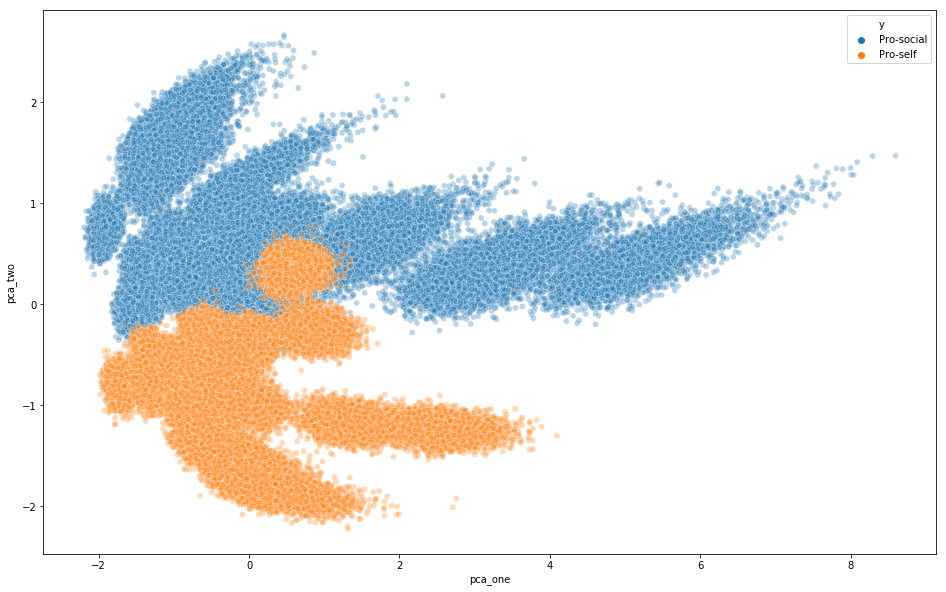

In [68]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca_one", y="pca_two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=traces,
    legend="full",
    alpha=0.3
)

In [69]:
tsne = TSNE(n_components=2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(traces[traces.columns[:-3]].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 196800 samples in 0.080s...
[t-SNE] Computed neighbors for 196800 samples in 6.468s...
[t-SNE] Computed conditional probabilities for sample 1000 / 196800
[t-SNE] Computed conditional probabilities for sample 2000 / 196800
[t-SNE] Computed conditional probabilities for sample 3000 / 196800
[t-SNE] Computed conditional probabilities for sample 4000 / 196800
[t-SNE] Computed conditional probabilities for sample 5000 / 196800
[t-SNE] Computed conditional probabilities for sample 6000 / 196800
[t-SNE] Computed conditional probabilities for sample 7000 / 196800
[t-SNE] Computed conditional probabilities for sample 8000 / 196800
[t-SNE] Computed conditional probabilities for sample 9000 / 196800
[t-SNE] Computed conditional probabilities for sample 10000 / 196800
[t-SNE] Computed conditional probabilities for sample 11000 / 196800
[t-SNE] Computed conditional probabilities for sample 12000 / 196800
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 122000 / 196800
[t-SNE] Computed conditional probabilities for sample 123000 / 196800
[t-SNE] Computed conditional probabilities for sample 124000 / 196800
[t-SNE] Computed conditional probabilities for sample 125000 / 196800
[t-SNE] Computed conditional probabilities for sample 126000 / 196800
[t-SNE] Computed conditional probabilities for sample 127000 / 196800
[t-SNE] Computed conditional probabilities for sample 128000 / 196800
[t-SNE] Computed conditional probabilities for sample 129000 / 196800
[t-SNE] Computed conditional probabilities for sample 130000 / 196800
[t-SNE] Computed conditional probabilities for sample 131000 / 196800
[t-SNE] Computed conditional probabilities for sample 132000 / 196800
[t-SNE] Computed conditional probabilities for sample 133000 / 196800
[t-SNE] Computed conditional probabilities for sample 134000 / 196800
[t-SNE] Computed conditional probabilities for sample 135000 / 196800
[t-SNE] Computed con

In [70]:
traces['tsne_one'] = tsne_results[:,0]
traces['tsne_two'] = tsne_results[:,1]

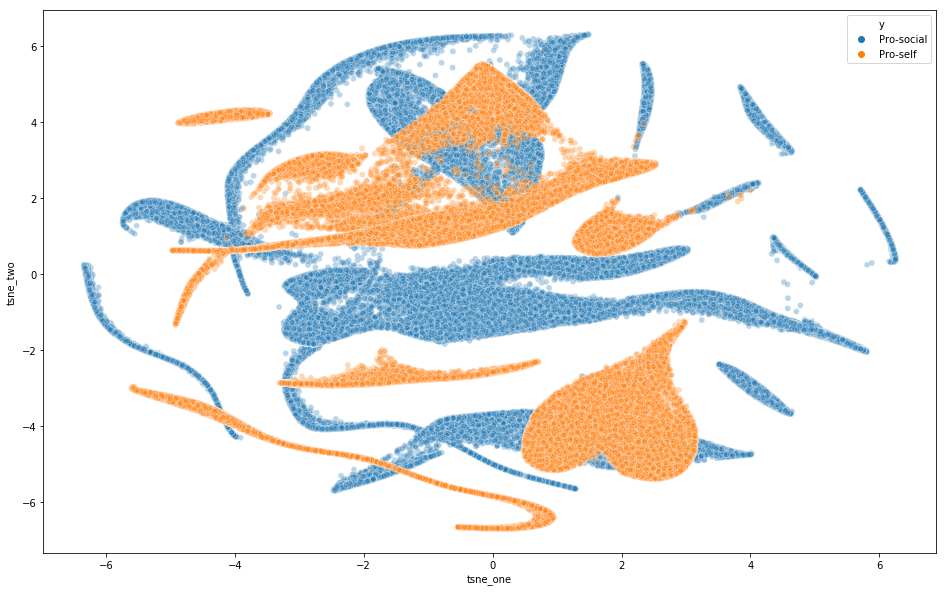

In [71]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_one", y="tsne_two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=traces,
    legend="full",
    alpha=0.3
)

In [72]:
modeler = ddm.HDDMmodelMaker()
soc_traces = pd.DataFrame()
sel_traces = pd.DataFrame()
model_soc = modeler.fit_model(train_fix.loc[(train_fix["type"] == "Pro-social")], 5000, 200)
model_sel = modeler.fit_model(train_fix.loc[(train_fix["type"] == "Pro-self")], 5000, 200)


 [-----------------100%-----------------] 5000 of 5000 complete in 32.2 sec

In [82]:
soc_traces = model_soc.get_traces()
sel_traces = model_sel.get_traces()
soc_traces["y"] = ["Pro-social"] * len(soc_traces.index)
sel_traces["y"] = ["Pro-self"] * len(sel_traces.index)
traces = soc_traces.append(sel_traces)
print (traces.columns[:-1])

Index([u'a', u't', u'v', u'z_trans'], dtype='object')


In [83]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(traces[traces.columns[:-1]].values)

In [84]:
traces["pca_one"] = pca_result[:,0]
traces["pca_two"] = pca_result[:,1]

In [85]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.99347672 0.00385387]


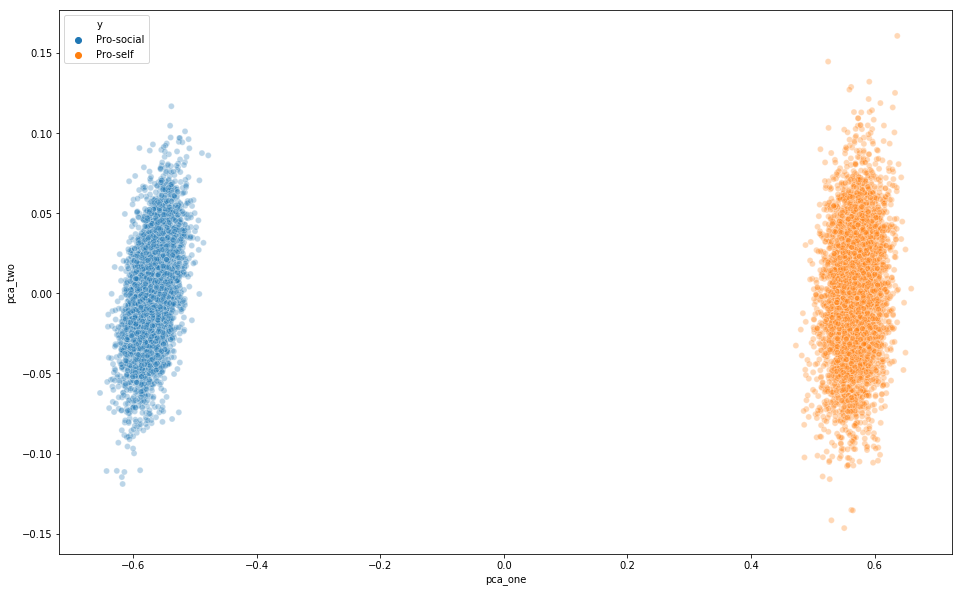

In [86]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca_one", y="pca_two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=traces,
    legend="full",
    alpha=0.3
)

In [87]:
tsne = TSNE(n_components=2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(traces[traces.columns[:-3]].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9600 samples in 0.002s...
[t-SNE] Computed neighbors for 9600 samples in 0.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9600
[t-SNE] Computed conditional probabilities for sample 2000 / 9600
[t-SNE] Computed conditional probabilities for sample 3000 / 9600
[t-SNE] Computed conditional probabilities for sample 4000 / 9600
[t-SNE] Computed conditional probabilities for sample 5000 / 9600
[t-SNE] Computed conditional probabilities for sample 6000 / 9600
[t-SNE] Computed conditional probabilities for sample 7000 / 9600
[t-SNE] Computed conditional probabilities for sample 8000 / 9600
[t-SNE] Computed conditional probabilities for sample 9000 / 9600
[t-SNE] Computed conditional probabilities for sample 9600 / 9600
[t-SNE] Mean sigma: 0.007802
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.664749
[t-SNE] KL divergence after 300 iterations: 2.490759


In [88]:
traces['tsne_one'] = tsne_results[:,0]
traces['tsne_two'] = tsne_results[:,1]

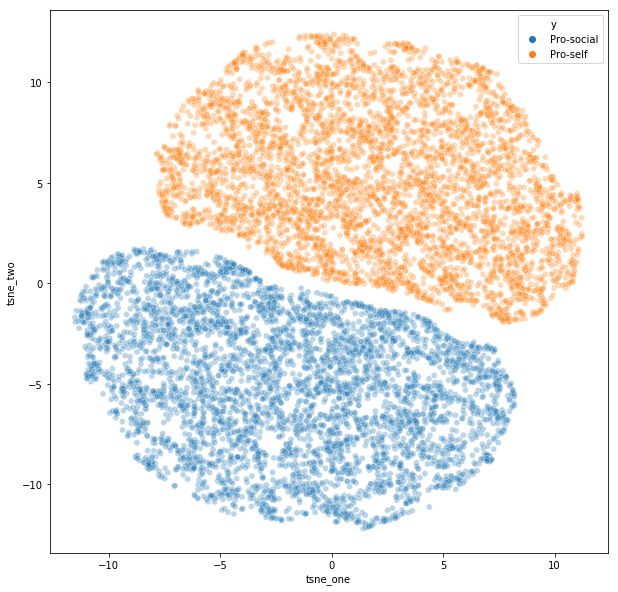

In [148]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne_one", y="tsne_two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=traces,
    alpha=0.3
)
plt.legend(loc = "best")


In [146]:
len(fix.player.unique())

58

In [149]:
len(data_svo.player.unique())

172